In [86]:
from pathlib import Path
import kagglehub

# Скачиваем (если уже есть — kagglehub вернёт кеш)
root = Path(kagglehub.dataset_download("grassknoted/asl-alphabet"))

# Внутри архива находятся две вложенные папки с тем же именем
train_dir = root / "asl_alphabet_train" / "asl_alphabet_train"
test_dir  = root / "asl_alphabet_test"  / "asl_alphabet_test"

print(f"train_dir → {train_dir}")
print(f"test_dir  → {test_dir}")

# Быстрая проверка, что папки существуют
assert train_dir.is_dir() and test_dir.is_dir(), "Dataset folders not found!"

train_dir → /Users/lvinnichenko/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train
test_dir  → /Users/lvinnichenko/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_test/asl_alphabet_test


In [87]:
import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from PIL import Image

import numpy as np

%matplotlib inline
# Установка стилистики графиков
plt.style.use('ggplot')

In [88]:
# Установка Seed для воспроизводимости
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [89]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [90]:
import torch
from torchvision import transforms

# Среднее и STD из ImageNet (совпадают с ResNet18_Weights.IMAGENET1K_V1.meta)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Базовая «цепочка» (одинакова для train / val / test на этом этапе)
basic_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                       # 1. масштаб до 224×224
    transforms.ConvertImageDtype(torch.float32),         # 2. HWC uint8 → CHW float32 [0,1]
    transforms.Normalize(mean=IMAGENET_MEAN,             # 3. нормализация «под ImageNet»
                         std=IMAGENET_STD)
])

transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

transforms_val   = basic_transforms  # можно заменить, если добавите аугментацию выше

print(basic_transforms)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ConvertImageDtype()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [91]:
import math
from sklearn.base import defaultdict
from torch.utils.data import Dataset, Subset
from torchvision.datasets import ImageFolder
import numpy as np

class DatasetPC(Dataset):
    def __init__(self, root, train=True, transform=None, split_ratio=0.8, seed=42):
        """
        Инициализация класса DatasetPC.

        :param root: Путь к директории с изображениями.
        :param train: Флаг, указывающий, является ли датасет тренировочным.
        :param transform: Трансформации, применяемые к изображениям.
        :param split_ratio: Доля данных, используемая для тренировки.
        :param seed: Значение seed для фиксации случайности.
        """
        self.root = root
        self.train = train
        self.transform = transform
        self.split_ratio = split_ratio
        self.seed = seed
        self.transform = transform

        # Загрузка всех изображений
        self.full_dataset = ImageFolder(root, transform=None)
        self.classes = self.full_dataset.classes
        self.class_to_idx = self.full_dataset.class_to_idx

        # Разделение датасета на тренировочные и валидационные данные с сохранением пропорций классов
        self.train_subset, self.val_subset = self._stratified_split()
        self.dataset = self.train_subset if train else self.val_subset

    def _stratified_split(self):
        """Возвращает два Subset (train, val), сохраняя долю классов,
        но не трогая сами изображения на диске."""
        labels = self.full_dataset.targets                     # list[int]

        # индексы каждого класса
        cls_to_idx = defaultdict(list)
        for idx, lbl in enumerate(labels):
            cls_to_idx[lbl].append(idx)

        random.seed(self.seed)

        train_idx, val_idx = [], []
        for idx_list in cls_to_idx.values():
            random.shuffle(idx_list)
            n_train = math.floor(len(idx_list) * self.split_ratio)
            train_idx.extend(idx_list[:n_train])
            val_idx.extend(idx_list[n_train:])

        return Subset(self.full_dataset, train_idx), Subset(self.full_dataset, val_idx)

    def __len__(self):
        """
        Возвращает количество изображений в датасете.

        :return: Количество изображений.
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Возвращает изображение и метку по индексу.

        :param idx: Индекс изображения.
        :return: Изображение и метка.
        """
        image, label = self.dataset[idx]
        image = torch.from_numpy(np.array(image)).permute(2,0,1)
        if self.transform:
            image = self.transform(image)
        return image, label

In [92]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision.io import decode_image, ImageReadMode

class ASLTestDataset(Dataset):
    """
    Тестовая папка содержит ровно по одному файлу на класс: A_test.jpg, B_test.jpg …
    Этот датасет выдаёт (tensor, label) и имеет поле .classes, совместимое с ImageFolder.
    """
    def __init__(self, root: Path, class_to_idx: dict[str, int], transform=None):
        self.files = sorted(root.glob("*.jpg"))          # 29 файлов
        self.class_to_idx = class_to_idx
        self.transform = transform

        # чтобы формат был таким же, как у ImageFolder
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}
        self.classes = [self.idx_to_class[i] for i in range(len(self.idx_to_class))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        label_str = path.stem.split("_")[0] # 'A_test' -> 'A'
        label = self.class_to_idx[label_str]

        img = decode_image(path, mode=ImageReadMode.RGB)
        if self.transform:
            img = self.transform(img)
        return img, label

In [93]:
ds_train = DatasetPC(root=train_dir, train=True,  transform=transforms_train)
ds_val   = DatasetPC(root=train_dir, train=False, transform=transforms_val)

# Официальный «по 1 файлу на класс» тест-набор
ds_test  = ASLTestDataset(root=test_dir,
                          class_to_idx=ds_train.class_to_idx,
                          transform=transforms_val)

# -------------------- печать статистики -----------------------------------
print(f"Train set : {len(ds_train):>5} images  |  {len(ds_train.classes)} classes")
print(f"Val set   : {len(ds_val):>5} images")
print(f"Test set  : {len(ds_test):>5} images  |  sample label={ds_test[0][1]} "
      f'("{ds_test.classes[ds_test[0][1]]}")')

Train set : 69600 images  |  29 classes
Val set   : 17400 images
Test set  :    28 images  |  sample label=0 ("A")


In [94]:
classes_list = ds_train.classes
print(classes_list)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


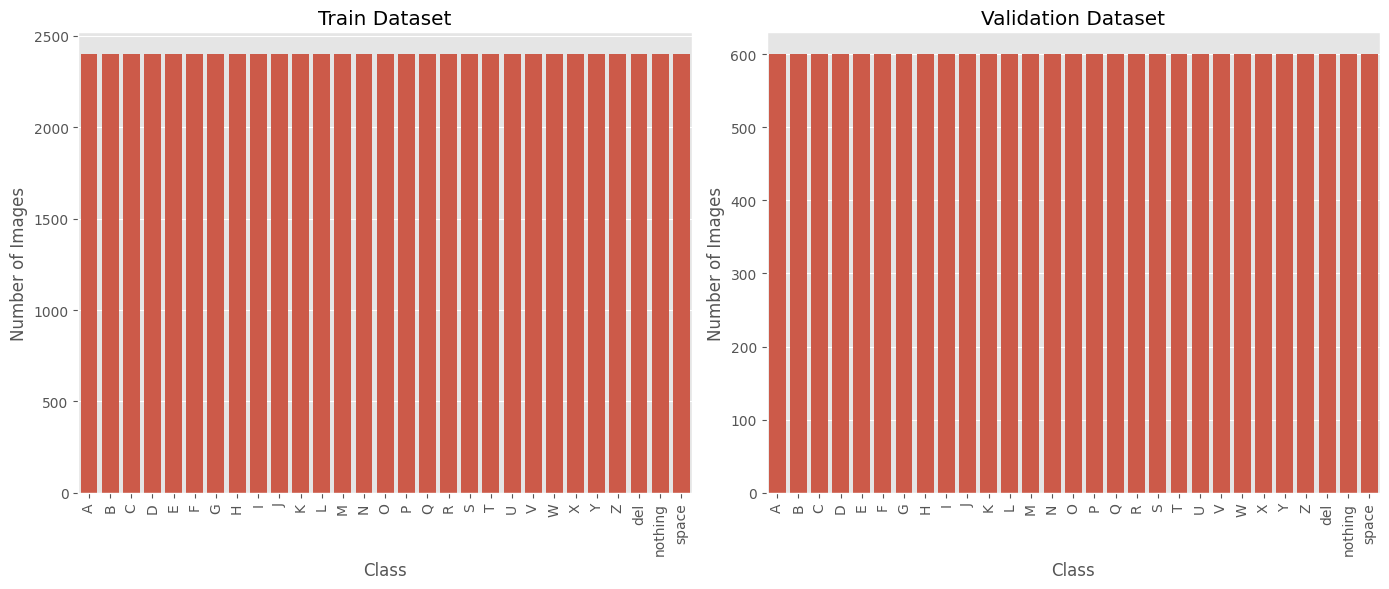

In [95]:
def count_labels(subset: torch.utils.data.Subset):
    base_dataset = subset.dataset          # ImageFolder
    idx_list     = subset.indices          # индексы выбранных примеров
    labels       = [base_dataset.targets[i] for i in idx_list]
    return np.bincount(labels, minlength=len(base_dataset.classes))

train_class_counts = count_labels(ds_train.dataset)
val_class_counts   = count_labels(ds_val.dataset)

# Создать barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot для обучающего набора данных
sns.barplot(x=ds_train.classes, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x', rotation=90)

# Barplot для валидационного набора данных
sns.barplot(x=ds_val.classes, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [96]:
from torch.utils.data import DataLoader
import torch, multiprocessing as mp

BATCH_SIZE      = 64               # можно 128, если GPU/-RAM позволяют
NUM_WORKERS     = 0 #mp.cpu_count()//2 or 1   # половина ядер — золотая середина
PIN_MEMORY      = torch.cuda.is_available()

train_loader = DataLoader(
    ds_train,
    batch_size     = BATCH_SIZE,
    shuffle        = True,          # перемешиваем каждый epoch
    num_workers    = NUM_WORKERS,
    pin_memory     = PIN_MEMORY,
    persistent_workers = NUM_WORKERS > 0,  # держим воркеры между эпохами
)

val_loader = DataLoader(
    ds_val,
    batch_size     = BATCH_SIZE,
    shuffle        = False,
    num_workers    = NUM_WORKERS,
    pin_memory     = PIN_MEMORY,
    persistent_workers = NUM_WORKERS > 0,
)

test_loader = DataLoader(
    ds_test,
    batch_size     = 1,             # по одному, их всего 29
    shuffle        = False,
    num_workers    = 0,             # воркеры тут не нужны
)
print(f"Loaders ready  |  workers per loader: {NUM_WORKERS}")

Loaders ready  |  workers per loader: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6555357..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5805322..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8256302..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].
Clippin

Images with class labels:


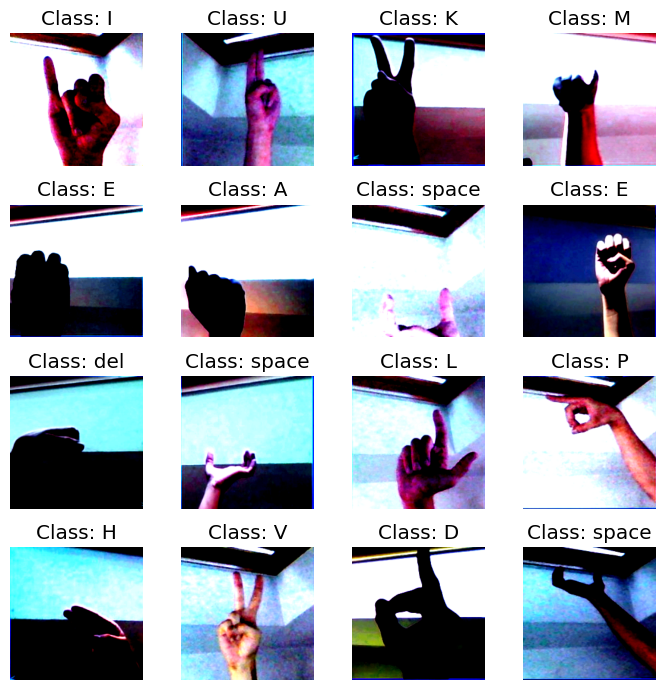

In [97]:
# Функция для отображения изображений из батча с метками классов
def show_images(images, labels, denormalize=False):
    if denormalize:
        # Обратное преобразование для нормализации
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        images = images.numpy().transpose((0, 2, 3, 1))
        images = std * images + mean
        images = np.clip(images, 0, 1)
    else:
        images = images.numpy().transpose((0, 2, 3, 1))

    fig, axes = plt.subplots(4, 4, figsize=(7, 7))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"Class: {classes_list[labels[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Получение первого батча из тренировочного загрузчика данных
images, labels = next(iter(train_loader))

# Отображение изображений с восстановлением цветов и метками классов
print("Images with class labels:")
show_images(images, labels, denormalize=False)

In [98]:
len(train_loader), len(val_loader)

(1088, 272)

In [99]:
img, label = next(iter(train_loader))

In [100]:
label

tensor([ 9,  1, 16, 27, 27, 27, 10,  6, 15,  2,  2,  0,  6,  2,  3,  1, 21, 28,
        12, 25, 11,  1, 12, 26, 21, 11,  1, 17, 26, 28, 19,  5, 23,  0, 15, 11,
         9, 10, 12, 25, 27,  4, 24,  4,  8, 18, 16, 14,  4, 24,  5, 25,  7, 27,
         4, 24, 25, 18, 27, 20, 23,  1, 25, 27])

In [101]:
ds_train[0]

(tensor([[[-1.8953, -0.0972,  0.5193,  ..., -1.7240, -1.9980, -2.0665],
          [-1.9124, -0.0801,  0.4851,  ..., -1.7069, -2.0152, -2.0837],
          [-1.9295, -0.0629,  0.5022,  ..., -1.6898, -2.0152, -2.1008],
          ...,
          [-1.9295, -0.6109, -0.2684,  ..., -0.7993, -2.0323, -2.0323],
          [-1.9295, -0.6281, -0.2342,  ..., -0.7993, -2.0152, -2.0665],
          [-1.9124, -0.6965, -0.2513,  ..., -0.7993, -1.9467, -2.1008]],
 
         [[-1.8431, -0.0749,  0.4328,  ..., -1.6331, -1.7731, -1.7381],
          [-1.8431, -0.0399,  0.3803,  ..., -1.5980, -1.7381, -1.7031],
          [-1.8256, -0.0049,  0.4328,  ..., -1.5630, -1.7031, -1.6856],
          ...,
          [-1.6331, -0.3725, -0.1800,  ..., -0.5476, -1.7381, -1.6681],
          [-1.6681, -0.3901, -0.1450,  ..., -0.5476, -1.7381, -1.7381],
          [-1.7206, -0.5476, -0.2150,  ..., -0.5826, -1.7031, -1.7731]],
 
         [[-0.1138,  1.2108,  0.8448,  ..., -0.0441,  1.0539,  1.6988],
          [-0.1487,  1.2282,

In [102]:
next(iter(train_loader))

[tensor([[[[ 0.6049,  0.5707,  0.5022,  ..., -0.7650, -1.2103, -2.1179],
           [ 0.4508,  0.4337,  0.4337,  ..., -0.7308, -1.2103, -2.1179],
           [ 0.4679,  0.4337,  0.4166,  ..., -0.5767, -1.1075, -2.1179],
           ...,
           [ 0.0569,  0.0741,  0.1083,  ..., -0.0629, -0.5424, -2.1179],
           [-0.6281, -0.6109, -0.5938,  ..., -0.6281, -1.0048, -2.1179],
           [-2.0665, -2.1179, -2.0837,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-0.0224, -0.0224, -0.0399,  ..., -0.8803, -1.1779, -1.9832],
           [-0.2150, -0.1800, -0.1275,  ..., -0.9678, -1.2304, -2.0357],
           [-0.2850, -0.2500, -0.1975,  ..., -0.7752, -1.1253, -2.0357],
           ...,
           [ 0.0826,  0.0651,  0.0826,  ...,  0.1702, -0.2850, -2.0357],
           [-0.4426, -0.4251, -0.4426,  ..., -0.3550, -0.7402, -1.9482],
           [-1.8431, -1.8782, -1.8606,  ..., -1.8782, -1.9657, -1.9832]],
 
          [[-0.4973, -0.4101, -0.4624,  ..., -0.3753,  0.7054,  1.7860],
           [-

In [103]:
from torchvision.models import resnet18, ResNet18_Weights

# Загрузим предварительно обученную модель ResNet18
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [104]:
num_classes = len(classes_list)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [105]:
model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
val_accuracy = correct / total
print(val_accuracy)

100%|██████████| 272/272 [01:12<00:00,  3.76it/s]

0.030862068965517242


In [106]:
class ResNet18ForFineTune(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

model = ResNet18ForFineTune()

In [107]:
model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
val_accuracy = correct / total
print(val_accuracy)

100%|██████████| 272/272 [01:12<00:00,  3.77it/s]

0.03505747126436782


In [108]:
def train(model, loss_fn, optimizer, dataloader):
    model.train()
    train_loss = 0
    train_acc = 0
    it_count = len(dataloader)
    print(f"it_count = {it_count}")
    with tqdm(total=it_count) as pbar:
        for batch, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            train_loss += loss.item()
            train_acc += (outputs.argmax(dim=1) == labels).float().mean().item()

            # Backprpagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.update(1)

            if batch % (it_count // 3) == 0:
                pbar.set_description(f"Train_loss: {round(train_loss / (batch + 1), 3)}" + f" Train_acc: {round(train_acc / (batch + 1), 3)}")

    return train_loss / it_count, train_acc / it_count


def test(model, loss_fn, dataloader):
    model.eval()
    test_loss = 0
    test_acc = 0
    it_count = len(dataloader)
    with tqdm(total=it_count) as pbar:
        with torch.no_grad():
            for batch, (images, labels) in enumerate(dataloader):
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                test_acc += (outputs.argmax(dim=1) == labels).float().mean().item()

                pbar.update(1)

                if batch % (it_count // 3) == 0:
                    pbar.set_description(f"Test_loss: {round(test_loss / (batch + 1), 3)}" + f" Test_acc: {round(test_acc / (batch + 1), 3)}")

    return test_loss / it_count, test_acc / it_count


def train_test_loop(model, loss_fn, optimizer, num_epochs):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    best_val_accuracy = 0

    model.to(device)
    for epoch in range(num_epochs):
        print(f"EPOCH {epoch}" + '-' * 100)
        loss, acc = train(model, loss_fn, optimizer, train_loader)
        train_losses.append(loss)
        train_accs.append(acc)

        loss, acc = test(model, loss_fn, val_loader)
        test_losses.append(loss)
        test_accs.append(acc)

        if acc > best_val_accuracy:
            best_val_accuracy = acc
            torch.save(model.state_dict(), 'best_model.pth')
            print('Saved best model!')

    # Сохранение последней актуальной модели
    torch.save(model.state_dict(), 'last_model.pth')
    print()

    return train_losses, test_losses, train_accs, test_accs

In [110]:
num_epochs = 5
model = ResNet18ForFineTune()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loop_info_finetune = train_test_loop(model, criterion, optimizer, num_epochs)

EPOCH 0----------------------------------------------------------------------------------------------------
it_count = 1088


Test_loss: 0.003 Test_acc: 1.0: 100%|██████████| 272/272 [01:47<00:00,  2.54it/s]


Saved best model!
EPOCH 1----------------------------------------------------------------------------------------------------
it_count = 1088


Train_loss: 0.01 Train_acc: 0.998:  54%|█████▍    | 588/1088 [11:14<09:33,  1.15s/it]


KeyboardInterrupt: 